In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data_path = "/home/rd81/projects/experiment_logs/REPEAT_2_SLICES_700_TIMES_WITH_SAVE_MINIMAL_DATA_2024-12-09_10-26-36/runs_data_['IXI105-HH-1471_t1.nii.gz']_2_slices.pt"
data = torch.load(data_path)


Detailed Metrics for Slice 0 (within brain mask):
Mean variance: 1.75e-03
Max variance: 1.83e-02
Mean CV: 3.90e-02
Std CV: 5.90e-02

Detailed Metrics for Slice 1 (within brain mask):
Mean variance: 1.61e-03
Max variance: 1.30e-02
Mean CV: 3.79e-02
Std CV: 5.85e-02


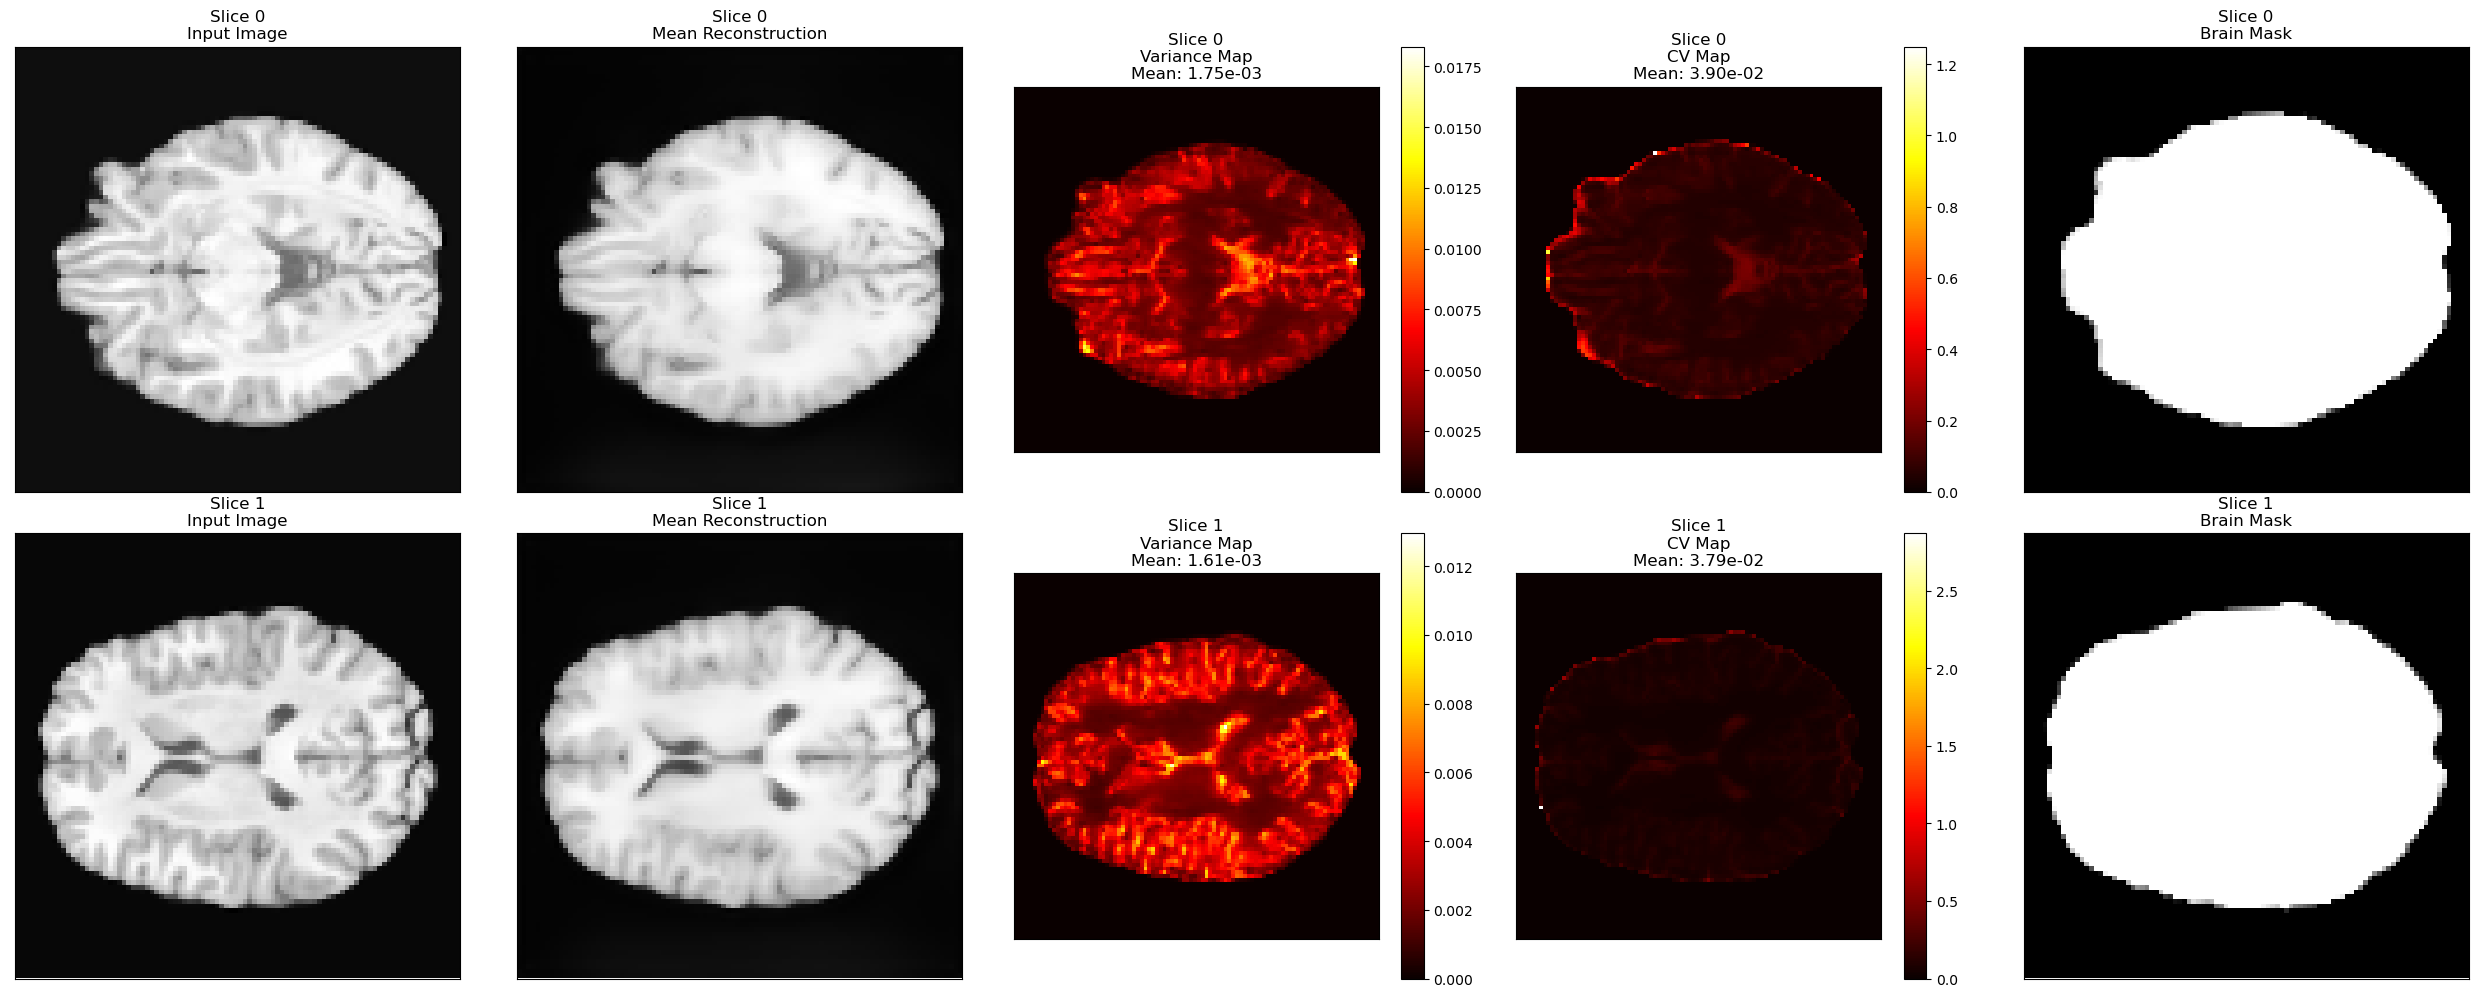

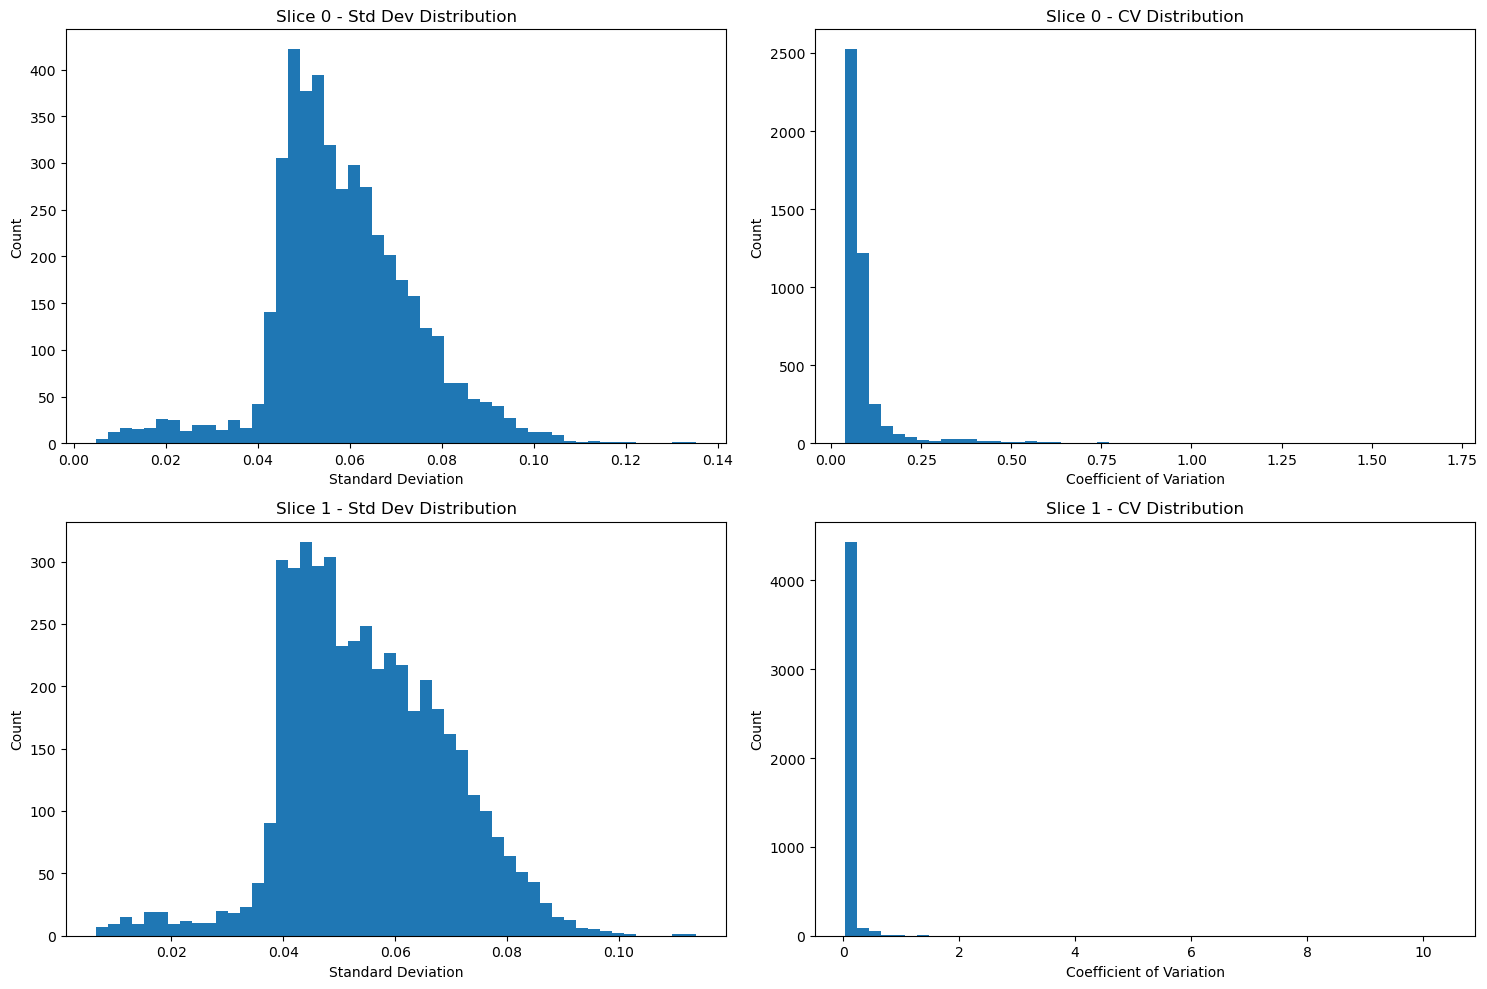

In [12]:
def analyze_and_visualize_reconstruction_consistency(data):
    """Analyze and visualize reconstruction variation across runs for each slice"""
    metrics = {}
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Added one more column for brain mask
    
    for slice_idx in range(data['input'].shape[1]):  # Iterate over slices
        # Get data for this slice
        slice_runs = data['reconstructions'][:, slice_idx]  # (n_runs, 96, 96)
        brain_mask = data['brain_mask'][0, slice_idx]  # Get mask for this slice (note: changed from brain_masks)
        input_slice = data['input'][0, slice_idx]  # Get the input image
        
        # Calculate statistics
        slice_var = torch.var(slice_runs, dim=0)
        slice_std = torch.std(slice_runs, dim=0)
        slice_mean = torch.mean(slice_runs, dim=0)
        
        # Calculate CV (Coefficient of Variation) within brain mask
        slice_cv = torch.where(slice_mean != 0, 
                             slice_std / torch.abs(slice_mean), 
                             torch.zeros_like(slice_std))
        slice_cv = slice_cv * brain_mask  # Apply mask
        
        # Store metrics
        metrics[f'slice_{slice_idx}'] = {
            'mean_variance': (slice_var * brain_mask).mean().item(),
            'max_variance': (slice_var * brain_mask).max().item(),
            'mean_cv': (slice_cv * brain_mask).mean().item(),
            'std_cv': (slice_cv * brain_mask).std().item()
        }
        
        # Plotting
        # Input image
        axes[slice_idx, 0].imshow(input_slice.cpu(), cmap='gray')
        axes[slice_idx, 0].set_title(f'Slice {slice_idx}\nInput Image')
        
        # Mean reconstruction
        axes[slice_idx, 1].imshow(slice_mean.cpu(), cmap='gray')
        axes[slice_idx, 1].set_title(f'Slice {slice_idx}\nMean Reconstruction')
        
        # Variance map
        var_img = axes[slice_idx, 2].imshow((slice_var * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 2].set_title(f'Slice {slice_idx}\nVariance Map\nMean: {metrics[f"slice_{slice_idx}"]["mean_variance"]:.2e}')
        plt.colorbar(var_img, ax=axes[slice_idx, 2])
        
        # CV map
        cv_img = axes[slice_idx, 3].imshow((slice_cv * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 3].set_title(f'Slice {slice_idx}\nCV Map\nMean: {metrics[f"slice_{slice_idx}"]["mean_cv"]:.2e}')
        plt.colorbar(cv_img, ax=axes[slice_idx, 3])
        
        # Brain mask
        axes[slice_idx, 4].imshow(brain_mask.cpu(), cmap='gray')
        axes[slice_idx, 4].set_title(f'Slice {slice_idx}\nBrain Mask')
        
        # Print detailed metrics
        print(f"\nDetailed Metrics for Slice {slice_idx} (within brain mask):")
        print(f"Mean variance: {metrics[f'slice_{slice_idx}']['mean_variance']:.2e}")
        print(f"Max variance: {metrics[f'slice_{slice_idx}']['max_variance']:.2e}")
        print(f"Mean CV: {metrics[f'slice_{slice_idx}']['mean_cv']:.2e}")
        print(f"Std CV: {metrics[f'slice_{slice_idx}']['std_cv']:.2e}")
    
    # Remove axes ticks for cleaner visualization
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Additional function to plot histograms of reconstruction variations
def plot_reconstruction_histograms(data):
    """Plot histograms of reconstruction variations for each slice"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for slice_idx in range(data['input'].shape[1]):
        slice_runs = data['reconstructions'][:, slice_idx]
        brain_mask = data['brain_mask'][0, slice_idx]
        
        # Calculate pixel-wise standard deviation
        std_dev = torch.std(slice_runs, dim=0)
        masked_std = std_dev[brain_mask > 0].cpu().numpy()
        
        # Calculate pixel-wise CV
        mean_recon = torch.mean(slice_runs, dim=0)
        cv = torch.where(mean_recon != 0,
                        torch.std(slice_runs, dim=0) / torch.abs(mean_recon),
                        torch.zeros_like(mean_recon))
        masked_cv = cv[brain_mask > 0].cpu().numpy()
        
        # Plot histograms
        axes[slice_idx, 0].hist(masked_std, bins=50)
        axes[slice_idx, 0].set_title(f'Slice {slice_idx} - Std Dev Distribution')
        axes[slice_idx, 0].set_xlabel('Standard Deviation')
        axes[slice_idx, 0].set_ylabel('Count')
        
        axes[slice_idx, 1].hist(masked_cv, bins=50)
        axes[slice_idx, 1].set_title(f'Slice {slice_idx} - CV Distribution')
        axes[slice_idx, 1].set_xlabel('Coefficient of Variation')
        axes[slice_idx, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Usage
metrics = analyze_and_visualize_reconstruction_consistency(data)
plot_reconstruction_histograms(data)

In [13]:
def analyze_and_visualize_reconstruction_consistency(data):
    """Analyze and visualize reconstruction variation across runs for each slice"""
    metrics = {}
    
    # Create figure with subplots - now 7 columns
    fig, axes = plt.subplots(2, 7, figsize=(35, 10))  # Increased figure width for new columns
    
    for slice_idx in range(data['input'].shape[1]):
        # Get data for this slice
        slice_runs = data['reconstructions'][:, slice_idx]
        brain_mask = data['brain_mask'][0, slice_idx]
        input_slice = data['input'][0, slice_idx]
        
        # Get mean noise and difference
        mean_noise = torch.mean(data['noise'][:, slice_idx], dim=0)
        mean_diff = torch.mean(data['differences'][:, slice_idx], dim=0)
        
        # Calculate statistics
        slice_var = torch.var(slice_runs, dim=0)
        slice_std = torch.std(slice_runs, dim=0)
        slice_mean = torch.mean(slice_runs, dim=0)
        
        # Calculate CV within brain mask
        slice_cv = torch.where(slice_mean != 0, 
                             slice_std / torch.abs(slice_mean), 
                             torch.zeros_like(slice_std))
        slice_cv = slice_cv * brain_mask
        
        metrics[f'slice_{slice_idx}'] = {
            'mean_variance': (slice_var * brain_mask).mean().item(),
            'max_variance': (slice_var * brain_mask).max().item(),
            'mean_cv': (slice_cv * brain_mask).mean().item(),
            'std_cv': (slice_cv * brain_mask).std().item(),
            'mean_difference': (mean_diff * brain_mask).mean().item()
        }
        
        # Plotting
        # Input image
        axes[slice_idx, 0].imshow(input_slice.cpu(), cmap='gray')
        axes[slice_idx, 0].set_title(f'Slice {slice_idx}\nInput Image')
        
        # Mean reconstruction
        axes[slice_idx, 1].imshow(slice_mean.cpu(), cmap='gray')
        axes[slice_idx, 1].set_title(f'Slice {slice_idx}\nMean Reconstruction')
        
        # Mean noise
        axes[slice_idx, 2].imshow(mean_noise.cpu(), cmap='gray')
        axes[slice_idx, 2].set_title(f'Slice {slice_idx}\nMean Noise')
        
        # Mean difference map
        diff_img = axes[slice_idx, 3].imshow((mean_diff * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 3].set_title(f'Slice {slice_idx}\nMean Difference\nMean: {metrics[f"slice_{slice_idx}"]["mean_difference"]:.2e}')
        plt.colorbar(diff_img, ax=axes[slice_idx, 3])
        
        # Variance map
        var_img = axes[slice_idx, 4].imshow((slice_var * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 4].set_title(f'Slice {slice_idx}\nVariance Map\nMean: {metrics[f"slice_{slice_idx}"]["mean_variance"]:.2e}')
        plt.colorbar(var_img, ax=axes[slice_idx, 4])
        
        # CV map
        cv_img = axes[slice_idx, 5].imshow((slice_cv * brain_mask).cpu(), cmap='hot')
        axes[slice_idx, 5].set_title(f'Slice {slice_idx}\nCV Map\nMean: {metrics[f"slice_{slice_idx}"]["mean_cv"]:.2e}')
        plt.colorbar(cv_img, ax=axes[slice_idx, 5])
        
        # Brain mask
        axes[slice_idx, 6].imshow(brain_mask.cpu(), cmap='gray')
        axes[slice_idx, 6].set_title(f'Slice {slice_idx}\nBrain Mask')
        
        # Print detailed metrics
        print(f"\nDetailed Metrics for Slice {slice_idx} (within brain mask):")
        print(f"Mean variance: {metrics[f'slice_{slice_idx}']['mean_variance']:.2e}")
        print(f"Max variance: {metrics[f'slice_{slice_idx}']['max_variance']:.2e}")
        print(f"Mean CV: {metrics[f'slice_{slice_idx}']['mean_cv']:.2e}")
        print(f"Std CV: {metrics[f'slice_{slice_idx}']['std_cv']:.2e}")
        print(f"Mean difference: {metrics[f'slice_{slice_idx}']['mean_difference']:.2e}")
    
    # Remove axes ticks for cleaner visualization
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    return metrics


Detailed Metrics for Slice 0 (within brain mask):
Mean variance: 1.75e-03
Max variance: 1.83e-02
Mean CV: 3.90e-02
Std CV: 5.90e-02
Mean difference: 3.38e-02

Detailed Metrics for Slice 1 (within brain mask):
Mean variance: 1.61e-03
Max variance: 1.30e-02
Mean CV: 3.79e-02
Std CV: 5.85e-02
Mean difference: 3.41e-02


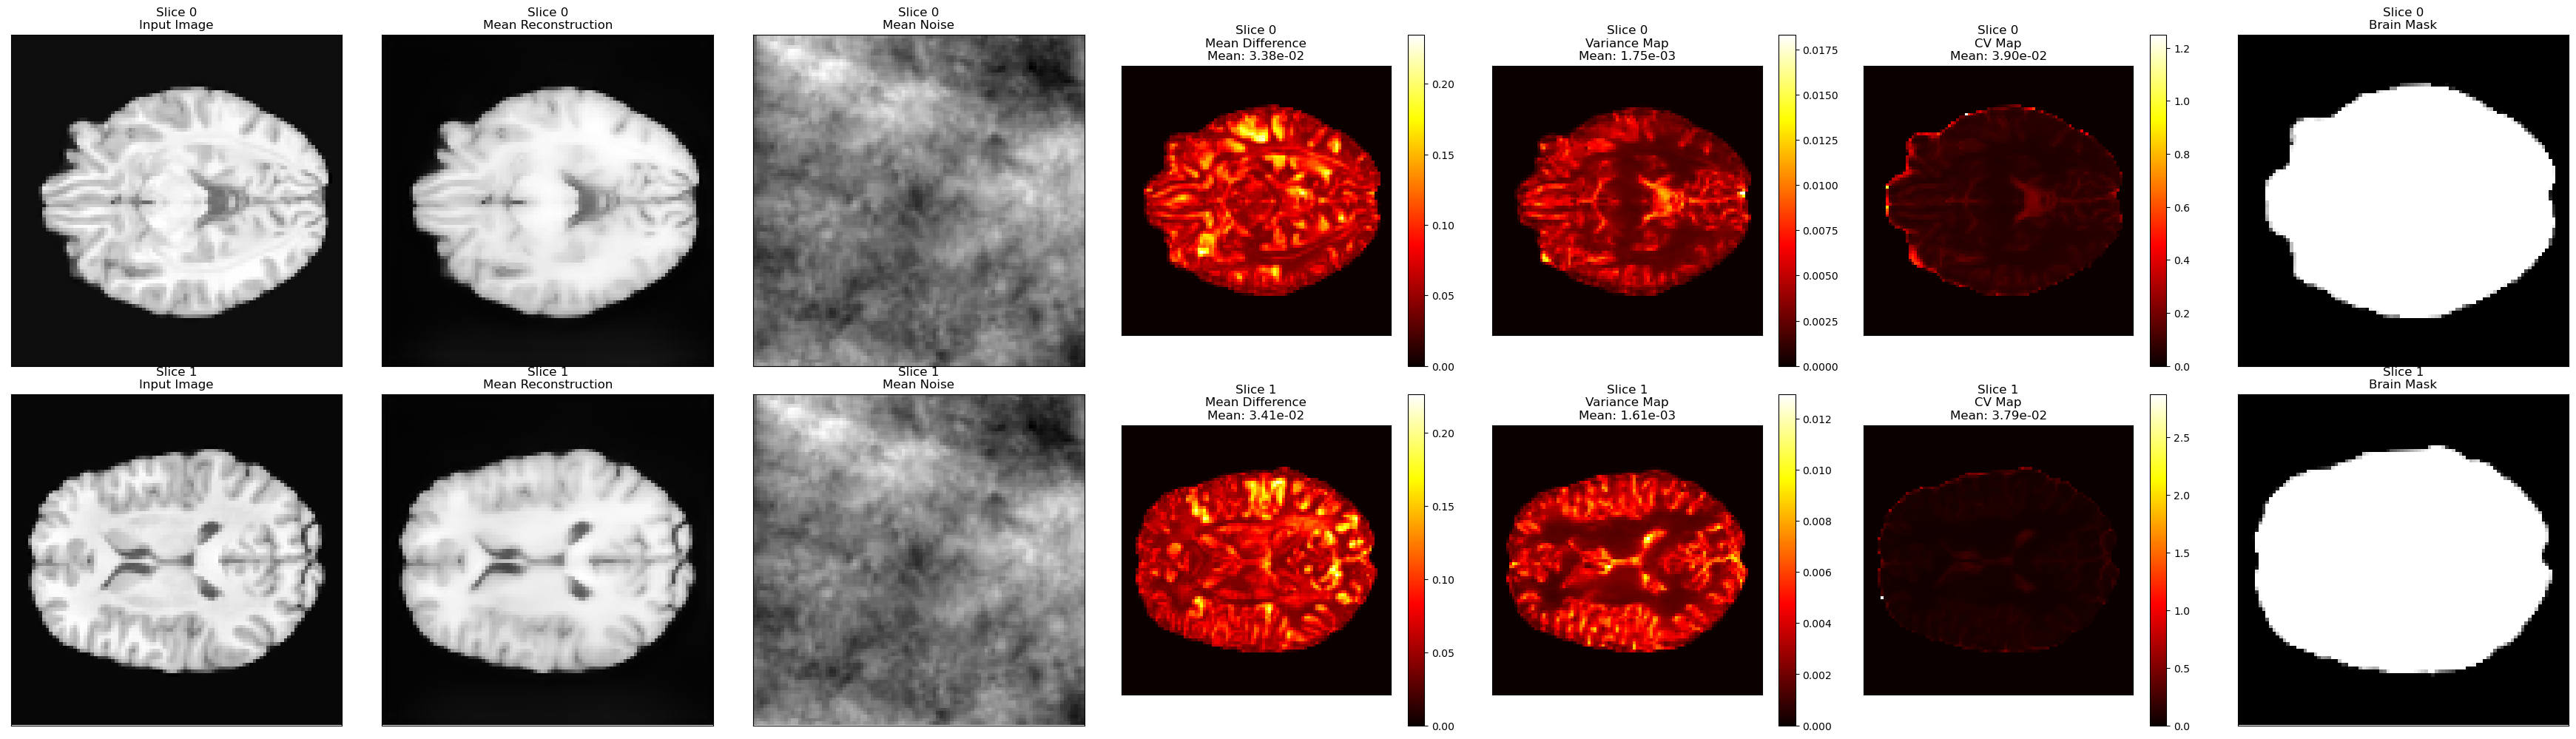

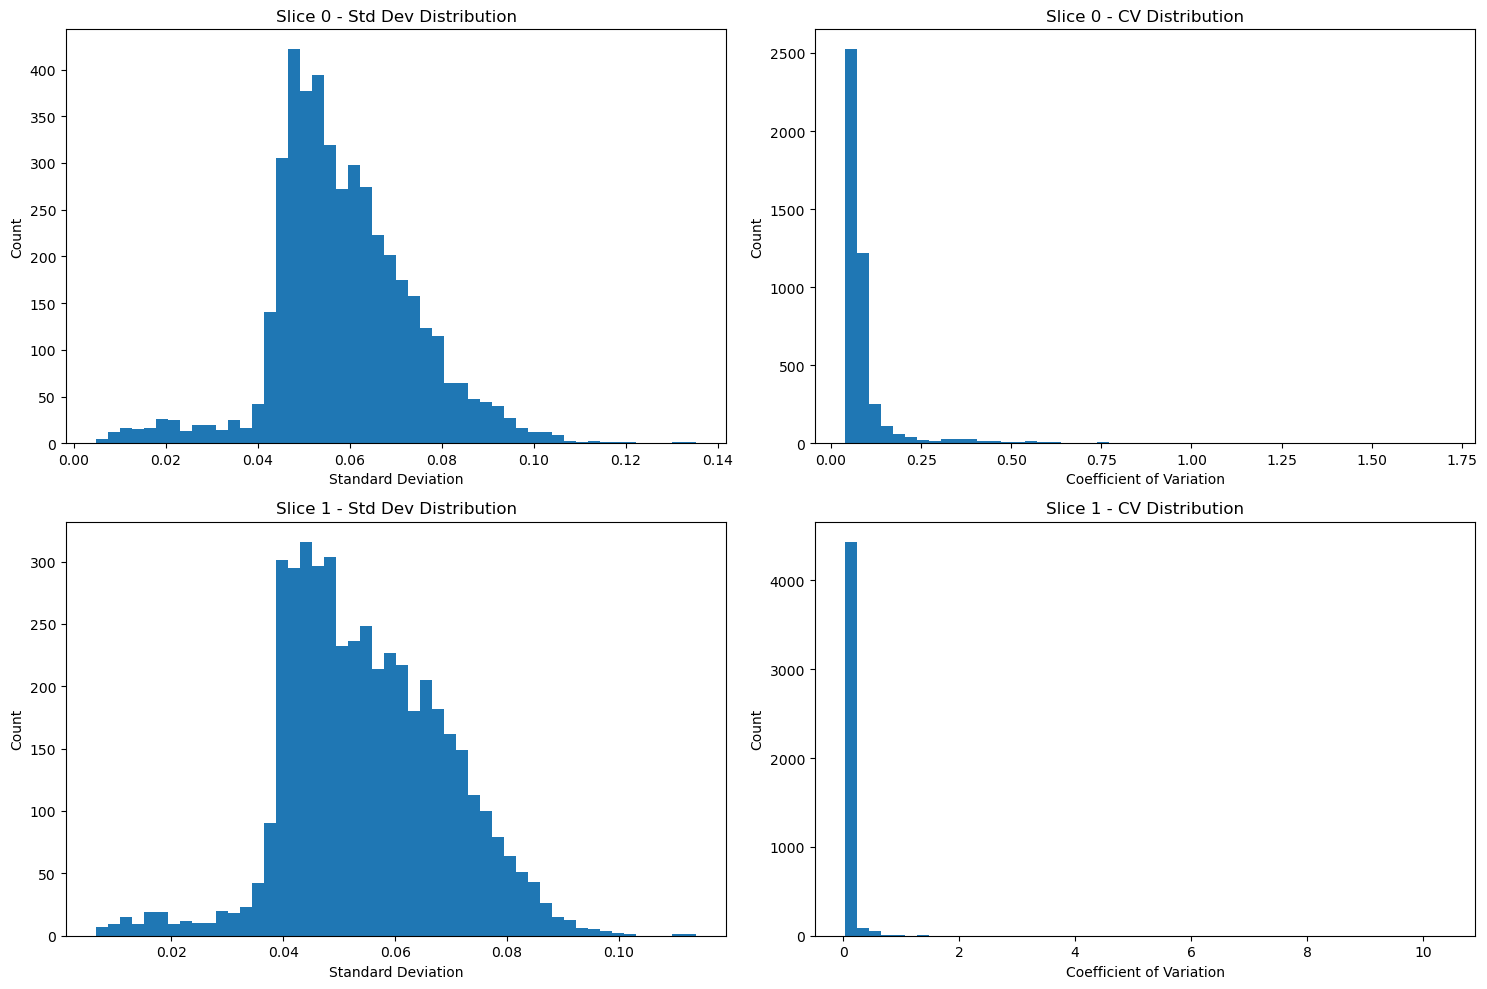

: 

In [ ]:
metrics = analyze_and_visualize_reconstruction_consistency(data)
plot_reconstruction_histograms(data)